In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import scipy as sp
from scipy.stats import norm
import networkx as nx

from graphite_maps.precision_estimation import fit_precision_cholesky, precision_to_graph

Set up a simple AR-1 example to test `graphite_maps` functionality.
$$u_t = \phi u_{t-1} + \epsilon,~~
 \epsilon\sim N(0,1) $$

In [2]:
# Define parameters
n = 1000  # Sample size
p = 10   # Dimension
phi = 0.6

In [3]:
# Simulate data
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x

np.random.seed(42)
U = np.array([rar1(T=p, phi=phi) for _ in range(n)])

We need the graph of conditional independence in $u$, 
thus create precision (which is conceptually unknown) and find graph from this (conceptually already known).

In [4]:
# create AR-1 precision matrix
prec = sp.sparse.diags(
    [np.repeat(-phi, p-1), np.concatenate(([1.0], np.repeat(1.0+phi**2, p-2), [1.0])), np.repeat(-phi, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)

Graph_u = precision_to_graph(prec)

Now use `graphite_maps` to estimate the precision w.r.t. $G_u$

In [5]:
prec_est, Graph_C, perm_compose, P_rev, P_order = fit_precision_cholesky(U, Graph_u, verbose_level=2)

max degree of graph is: 4
Permutation optimization took 0.0008182525634765625 seconds
Parameters in precision: 19
Parameters in Cholesky factor: 12
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1939.92it/s]

Precision has log-determinant: -0.5068298325318323


Inspect that the result seem to converge (no values should be too large here).

In [6]:
print(prec_est.A - prec.A)
print(np.max(np.abs(prec_est-prec)))

[[-0.004  0.009  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.009 -0.005 -0.033  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.033  0.032 -0.008  0.    -0.001  0.     0.     0.     0.   ]
 [ 0.     0.    -0.008  0.005  0.024  0.009  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.024 -0.054  0.046  0.     0.     0.     0.   ]
 [ 0.     0.    -0.001  0.009  0.046 -0.148  0.102 -0.035  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.102 -0.13   0.081  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.035  0.081 -0.047 -0.017  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.017  0.063 -0.066]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.066  0.117]]
0.14766798993911223


In [7]:
print(np.linalg.inv(prec_est.A) - np.linalg.inv(prec.A))
print(np.max(np.abs(np.linalg.inv(prec_est.A)-np.linalg.inv(prec.A))))

[[ 0.014  0.026  0.028  0.011  0.002 -0.003 -0.008 -0.003 -0.002 -0.001]
 [ 0.026  0.061  0.057  0.024  0.006 -0.002 -0.012 -0.005 -0.003 -0.002]
 [ 0.028  0.057  0.016 -0.006 -0.017 -0.02  -0.029 -0.014 -0.008 -0.005]
 [ 0.011  0.024 -0.006 -0.043 -0.049 -0.046 -0.055 -0.027 -0.016 -0.01 ]
 [ 0.002  0.006 -0.017 -0.049 -0.017 -0.023 -0.062 -0.027 -0.016 -0.01 ]
 [-0.003 -0.002 -0.02  -0.046 -0.023  0.056 -0.051 -0.013 -0.007 -0.006]
 [-0.008 -0.012 -0.029 -0.055 -0.062 -0.051 -0.018 -0.053 -0.031 -0.021]
 [-0.003 -0.005 -0.014 -0.027 -0.027 -0.013 -0.053  0.007  0.006  0.   ]
 [-0.002 -0.003 -0.008 -0.016 -0.016 -0.007 -0.031  0.006 -0.02  -0.018]
 [-0.001 -0.002 -0.005 -0.01  -0.01  -0.006 -0.021  0.    -0.018 -0.119]]
0.11894178630404029


[5 7 6 8 9 2 3 4 1 0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


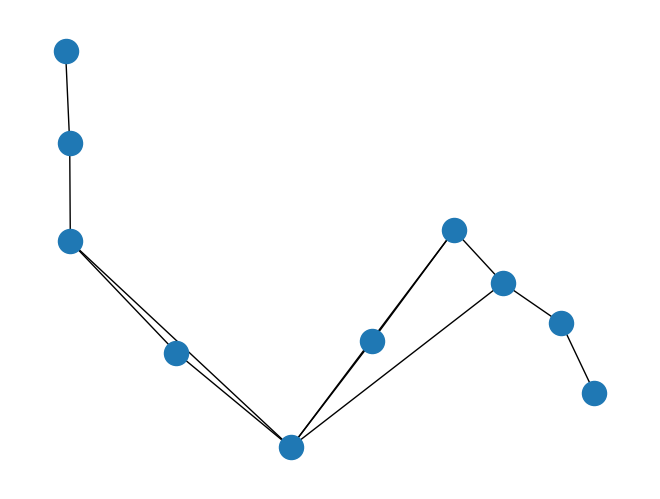

In [8]:
nx.draw(Graph_C)
print(perm_compose)
print(P_rev.A)
print(P_order.A)